In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as stats
import seaborn as sns
import pingouin as pg
from sklearn.linear_model import LinearRegression
import random
import warnings
import statsmodels.formula.api as smf
from matplotlib.lines import Line2D
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster
from statsmodels.stats.anova import anova_lm

warnings.filterwarnings("ignore")

# Figure 1

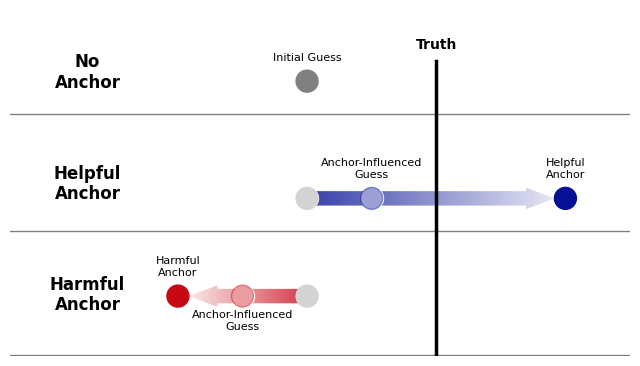

In [2]:
fig, ax = plt.subplots(figsize=(8, 4.5))

colors = ['grey','lightgrey','#051094','#051094','#C80815', '#C80815', 'lightgrey']
values = [200, 200, 250, 400, 100, 150, 200]
ys = [1.165, 1.075,1.075,1.075,1,1,1]
alphas = [1, 1, .4, 1, 1, .4, 1]

# Gradient Arrows
def create_gradient(x_1, x_2, y, n, direction):
    delta_x = (x_2 - x_1) / n   
    for i in range(n):
        if direction:
            alpha_val = .2 + (i/n * .7)
        else:
            alpha_val = .9 - (i/n * .7)
        ax.add_patch(mpatches.Rectangle((x_1+delta_x*i, y), delta_x, .05, fill=True, lw=0, color='w', alpha=alpha_val))
arrow1 = mpatches.FancyArrow(200, 1.075, 190, 0, width=0.01, color='#051094', edgecolor='lightgray', head_width=.015, head_length=20, length_includes_head = True)
arrow2 = mpatches.FancyArrow(200,1, -90, 0, width=0.01, color='#C80815', edgecolor='lightgray', head_width=.015, head_length=20, length_includes_head = True)
ax.add_patch(arrow1)
ax.add_patch(arrow2)
create_gradient(200, 390, 1.05, 100, True)
create_gradient(110, 200, .975, 80, False)

scatter = ax.scatter(values, ys, s=250, c='white', marker='o')
scatter = ax.scatter(values, ys, s=250, c=colors, marker='o', alpha = alphas)



labels = ["Initial Guess",
        "Anchor-Influenced\nGuess", 
        "Helpful\nAnchor",
        "Harmful\nAnchor", 
        "Anchor-Influenced\nGuess"]

xs = [200, 250, 400, 100, 150]
ys = [1.165, 1.075,1.075,1,1]
for i, txt in enumerate(labels):
    if i == 4:
        m = -24
    else:
        m = 15
    ax.annotate(txt, (xs[i], ys[i]), textcoords="offset points", xytext=(0,m), ha='center', fontsize=8)

ax.annotate("Truth", (300, 1.19), textcoords="offset points", xytext=(0,0), ha='center', fontsize=10, weight='bold')
ax.annotate("No\nAnchor", (30, 1.16), textcoords="offset points", xytext=(0,0), ha='center', fontsize=12, weight='bold')
ax.annotate("Helpful\nAnchor", (30, 1.08), textcoords="offset points", xytext=(0,-5), ha='center', fontsize=12, weight='bold')
ax.annotate("Harmful\nAnchor", (30, 1), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=12, weight='bold')


ax.axhline(y=1.14, color='gray', linestyle='-', linewidth=1)
ax.axhline(y=1.05, color='gray', linestyle='-', linewidth=1)
ax.axhline(y=0.955, color='gray', linestyle='-', linewidth=1)


ax.set_ylim(0.954, 1.22)
ax.axvline(x=300, ymin = 0, ymax=0.85, color='k', linestyle='-', linewidth=2.5)
ax.set_xlim(-30, 450)
ax.set_xticks([])
ax.get_yaxis().set_visible(False)
for spine in ax.spines.values():
    spine.set_visible(False)
#plt.savefig('Figures/Figure-1_Types-of-Anchors.png', dpi=300)
plt.show()


# Load data

In [3]:
# Read in data and create composite variables
df = pd.read_csv('ci_cb_2023-06-26.csv')

df['Anchor'] = np.where(df['Condition'] == 'Low', 118, 353)
df['Mag_Rev1'] = abs(df['response_2'] - df['response_1'])
df['Mag_Rev2'] = abs(df['response_3'] - df['response_2'])
df['Mag_Rev'] = abs(df['response_3'] - df['response_1'])
df['Initial_Error'] = abs(df['response_1'] - df['true_answer'])
df['Second_Error'] = abs(df['response_2'] - df['true_answer'])
df['Final_Error'] = abs(df['response_3'] - df['true_answer'])
df['Dist_Anchor_1'] = abs(df['response_1'] - df['Anchor'])
df['Dist_Anchor_2'] = abs(df['response_2'] - df['Anchor'])
df['Dist_Anchor_3'] = abs(df['response_3'] - df['Anchor'])
df['Difference_Initial_Anchor'] = df['response_1'] - df['Anchor']
df['Difference_Initial_Truth'] = df['response_1'] - 246
df['Matched'] = np.where(df['Difference_Initial_Anchor'] * df['Difference_Initial_Truth'] > 0, 1, 0)
df['Change_accuracy'] = df['Initial_Error'] - df['Final_Error']

# Load data from previous experiment which asked this question without anchoring
df_old = pd.read_csv('pnas.1615978114.sd01.csv')
df_old = df_old.loc[(df_old.task == '4d')]
df_old = df_old.dropna(subset=['response_1'])

In [5]:
df_low = df[df['Condition'] == 'Low']
df_high = df[df['Condition'] == 'High']


# Medians show significant difference between these groups:
print(stats.mannwhitneyu(df_low['response_1'].dropna(), df_high['response_1'].dropna()))
print('Low Median', df_low['response_1'].median(), 'High Median', df_high['response_1'].median())
print('Anchoring Index:',(df_high['response_1'].median() - df_low['response_1'].median()) / (353 - 118))

# Some outliers make means less useful, though they show the same effect:
print('\nMeans:')
print(stats.ttest_ind(df_low['response_1'].dropna(), df_high['response_1'].dropna()))
print('Low SD', df_low['response_1'].std(), 'High SD', df_high['response_1'].std())
print('Low mean', df_low['response_1'].mean(), 'High mean', df_high['response_1'].mean())
print('Anchoring Index:',(df_high['response_1'].mean() - df_low['response_1'].mean()) / (353 - 118))


df_old = pd.read_csv('pnas.1615978114.sd01.csv')
df_old = df_old.loc[(df_old.task == '4d')]
print('\nUnanchored Old:', df_old.response_1.median())

MannwhitneyuResult(statistic=153410.5, pvalue=1.0356426713987777e-41)
Low Median 141.0 High Median 200.0
Anchoring Index: 0.251063829787234

Means:
TtestResult(statistic=-2.6927812732407044, pvalue=0.007167945523465154, df=1442.0)
Low SD 85.26993168071965 High SD 1261.708934868459
Low mean 161.7080394922426 High mean 289.58639455782316
Anchoring Index: 0.5441632130450237

Unanchored Old: 185.0


# Figure 2

In [6]:
away, toward, away_cis, toward_cis = [], [], [], []

# Individual level distance to the anchor; groupby network to account for interactions
for cond in ['Network','Control']:
      df_temp = df.loc[df.Net_type == cond].dropna(subset=['Matched', 'Dist_Anchor_1', 'Dist_Anchor_2', 'Dist_Anchor_3'])
      df_temp = df_temp.groupby(['group','Matched']).agg({'Dist_Anchor_1': np.median,'Dist_Anchor_2': np.median,'Dist_Anchor_3': np.median})
      df_temp['Change_in_Distance'] = df_temp['Dist_Anchor_3'] - df_temp['Dist_Anchor_1']
      df_temp = df_temp.reset_index(level=['Matched'])


      away.append(df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].mean())
      toward.append(df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].mean())
      away_cis.append(1.96*df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))
      toward_cis.append(1.96*df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))

df_individuals = pd.DataFrame({'Away':away, 'Toward':toward, 'Away_cis':away_cis, 'Toward_cis':toward_cis})


away, toward, away_cis, toward_cis = [], [], [], []

# Group level distance to the anchor
for cond in ['Network','Control']:
    df_temp = df.loc[df.Net_type == cond]
    df_temp = df_temp.groupby('group').agg({'response_1': np.median, 'response_3': np.median, 'Anchor': np.median})

    # Calculate Crowd performance
    df_temp['Dif_1'] = abs(df_temp.response_1 - df_temp.Anchor)
    df_temp['Dif_3'] = abs(df_temp.response_3 - df_temp.Anchor)
    df_temp['Change'] =  df_temp['Dif_3'] - df_temp['Dif_1']

    # Group by whether the anchor is in the direction of truth (Matched == 1) or not (Matched == 0)
    df_temp['Difference_Initial_Anchor'] = df_temp['response_1'] - df_temp['Anchor']
    df_temp['Difference_Initial_Truth'] = df_temp['response_1'] - 246
    df_temp['Matched'] = np.where(df_temp['Difference_Initial_Anchor'] * df_temp['Difference_Initial_Truth'] > 0, 1, 0)
    df_t = df_temp.loc[df_temp.Matched == 1].dropna(subset=['Dif_1', 'Dif_3'])
    df_f = df_temp.loc[df_temp.Matched == 0].dropna(subset=['Dif_1', 'Dif_3'])

    away.append(df_f['Change'].mean())
    toward.append(df_t['Change'].mean())
    away_cis.append(1.96 * df_f['Change'].std() / np.sqrt(df_f['Change'].count()))
    toward_cis.append(1.96 * df_t['Change'].std() / np.sqrt(df_t['Change'].count()))

df_groups = pd.DataFrame({'Away':away, 'Toward':toward, 'Away_cis':away_cis, 'Toward_cis':toward_cis})



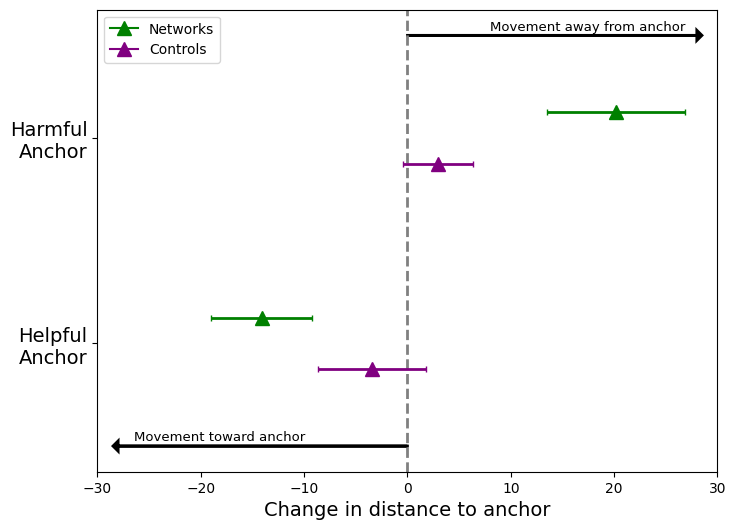

In [7]:
# Create a similar figure, except make it a single plot and insteaad of bars, plot points and 95% confidence intervals. Do this vertically

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
axs.plot([0,0],[-1,5],'--',color='gray',lw=2)
df_individual = df_individuals
axs.plot(df_individual['Away'].iloc[0], [3.75],color='green', ms=10, marker = '^', label = 'Networks')
axs.errorbar(df_individual['Away'].iloc[0], [3.75], xerr=df_individual['Away_cis'].iloc[0], fmt='none', ecolor='green', capsize=2, lw=2)
axs.plot(df_individual['Away'].iloc[1], [3.25],color='purple', ms=10, marker = '^', label = 'Controls')
axs.errorbar(df_individual['Away'].iloc[1], [3.25], xerr=df_individual['Away_cis'].iloc[1], fmt='none', ecolor='purple', capsize=2, lw=2)


axs.plot(df_individual['Toward'].iloc[0], [1.75],color='green', ms=10, marker = '^')
axs.errorbar(df_individual['Toward'].iloc[0], [1.75], xerr=df_individual['Toward_cis'].iloc[0], fmt='none', ecolor='green', capsize=2, lw=2)
axs.plot(df_individual['Toward'].iloc[1], [1.25],color='purple', ms=10, marker = '^')
axs.errorbar(df_individual['Toward'].iloc[1], [1.25], xerr=df_individual['Toward_cis'].iloc[1], fmt='none', ecolor='purple', capsize=2, lw=2)

axs.arrow(0, 4.5, 28, 0, head_width=0.1, head_length=0.5, fc='k', ec='k', lw=2)
axs.arrow(0, 0.5, -28, 0, head_width=0.1, head_length=0.5, fc='k', ec='k', lw=2)


axs.set_yticks([1.5,3.5])
axs.set_yticklabels(['Helpful\nAnchor', 'Harmful\nAnchor'],fontsize=14)
axs.set_xlabel('Change in distance to anchor',fontsize=14)
axs.text(8,4.55,'Movement away from anchor',fontsize=9.5)
axs.text(-26.5,0.55,'Movement toward anchor',fontsize=9.5)
axs.set_ylim(0.25,4.75)
axs.set_xlim(-30,30)
axs.legend()
plt.show()


In [8]:
df = df.dropna(subset=['response_1'])
print('Helpful:',df.loc[df['Matched'] == 1].shape[0])
print('Harmful:',df.loc[df['Matched'] == 0].shape[0])

Helpful: 809
Harmful: 635


In [ ]:

print('Percentage_Changes')
# HARMFUL & HELPFUL
df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby(['group','Matched']).agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Dist_Anchor_1': np.median,
                                            'Dist_Anchor_2': np.median, 'Dist_Anchor_3': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_con = df_temp_con
df_con.reset_index(level=['Matched'], inplace=True)
df_con['R_1'] = 0
df_con['R_2'] = (1 - df_con['Dist_Anchor_2'] / df_con['Dist_Anchor_1']) * 100
df_con['R_3'] = (1 - df_con['Dist_Anchor_3'] / df_con['Dist_Anchor_1']) * 100


df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby(['group','Matched']).agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Dist_Anchor_1': np.median,
                                              'Dist_Anchor_2': np.median, 'Dist_Anchor_3': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_net = df_temp
df_net.reset_index(level=['Matched'], inplace=True)
df_net = df_temp
df_net['R_1'] = 0
df_net['R_2'] = (1 - df_net['Dist_Anchor_2'] / df_net['Dist_Anchor_1']) * 100
df_net['R_3'] = (1 - df_net['Dist_Anchor_3'] / df_net['Dist_Anchor_1']) * 100

print('\nBy network Helpful')

df_temp = df_net.loc[df_net.Matched == 1]
df_temp_con = df_con.loc[df_con.Matched == 1]
print('Percentage change:',np.mean(df_temp['R_3']) - np.mean(df_temp_con['R_3']))

print('\nHarmful')
df_temp = df_net.loc[df_net.Matched == 0]
df_temp_con = df_con.loc[df_con.Matched == 0]
print('Percentage change:',np.mean(df_temp['R_3']) - np.mean(df_temp_con['R_3']))


print('\nDifferences between conditions:')
df_net['Change_in_Distance'] = df_net['Dist_Anchor_3'] - df_net['Dist_Anchor_1']
df_con['Change_in_Distance'] = df_con['Dist_Anchor_3'] - df_con['Dist_Anchor_1']

print('Helpful:',df_net.loc[df_net.Matched == 1]['Change_in_Distance'].mean(), df_con.loc[df_con.Matched == 1]['Change_in_Distance'].mean())
print('Network only',stats.wilcoxon(df_net.loc[df_net.Matched == 1]['Change_in_Distance']))
print("Compared to control",stats.mannwhitneyu(df_net.loc[df_net.Matched == 1]['Change_in_Distance'], df_con.loc[df_con.Matched == 1]['Change_in_Distance']))

print('\nHarmful:',df_net.loc[df_net.Matched == 0]['Change_in_Distance'].mean(), df_con.loc[df_con.Matched == 0]['Change_in_Distance'].mean())
print('Network only',stats.wilcoxon(df_net.loc[df_net.Matched == 0]['Change_in_Distance']))
print("Compared to control",stats.mannwhitneyu(df_net.loc[df_net.Matched == 0]['Change_in_Distance'], df_con.loc[df_con.Matched == 0]['Change_in_Distance']))


Percentage_Changes

By network Helpful
Percentage change: 13.551811477933128

Harmful
Percentage change: -28.734482307574563

Differences between conditions:
Helpful: -14.125 -3.45
Network only WilcoxonResult(statistic=19.0, pvalue=0.0005855560302734375)
Compared to control MannwhitneyuResult(statistic=69.5, pvalue=0.0004340060463465756)

Harmful: 20.175 2.975
Network only WilcoxonResult(statistic=0.0, pvalue=0.00019540793740897318)
Compared to control MannwhitneyuResult(statistic=305.5, pvalue=0.004389968439207104)


# Error across rounds

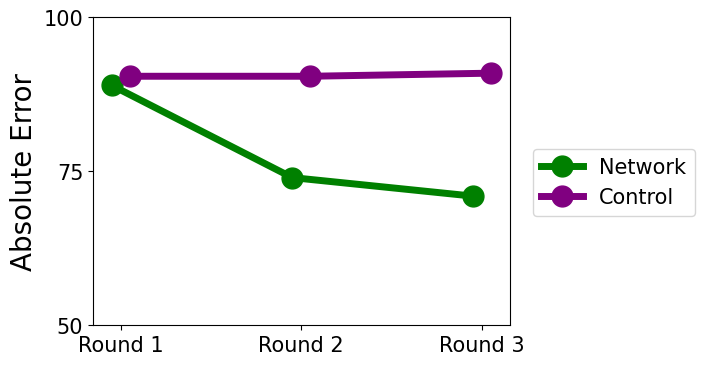

In [15]:
df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                            'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_con = df_temp_con


df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                              'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_net = df_temp

fig, axs = plt.subplots(1, 1, figsize=(7, 4))

axs.plot([-0.05, .95, 1.95],[df_net[i].mean() for i in ['Initial_Error', 'Second_Error', 'Final_Error']], '-o', color='green', ms = 15, lw=5, label='Network')
axs.plot([0.05, 1.05, 2.05],[df_con[i].mean() for i in ['Initial_Error', 'Second_Error', 'Final_Error']], '-o', color='purple', ms = 15, lw=5, label='Control')

axs.set_xticks([0, 1, 2], ['Round 1', 'Round 2', 'Round 3'], fontsize=15)
axs.set_ylabel('Absolute Error', fontsize=20)
axs.set_ylim(50, 100)
axs.set_yticks([50, 75, 100], ['50', '75', '100'], fontsize=15)
fig.legend(fontsize=15,loc='center right')
plt.subplots_adjust(right=0.72)
plt.savefig('Figures/Figure-3_Change-Error.png', dpi=300)
plt.show()



In [16]:
# Percentage ERROR

# OVERALL
df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                            'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_con = df_temp_con
df_con['R_1'] = 0
df_con['R_2'] = (1 - df_con['Second_Error'] / df_con['Initial_Error']) * 100
df_con['R_3'] = (1 - df_con['Final_Error'] / df_con['Initial_Error']) * 100

df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                              'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_net = df_temp
df_net['R_1'] = 0
df_net['R_2'] = (1 - df_net['Second_Error'] / df_net['Initial_Error']) * 100
df_net['R_3'] = (1 - df_net['Final_Error'] / df_net['Initial_Error']) * 100

print('Individual = OVER ALL the conditions (i.e., low and high anchor)')
print('Percentage change:',np.mean(df_net['R_3']) - np.mean(df_con['R_3']))
print(stats.mannwhitneyu(df_net['R_3'], df_con['R_3']))



# HARMFUL & HELPFUL
df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby(['group','Matched']).agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                            'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_con = df_temp_con
df_con.reset_index(level=['Matched'], inplace=True)
df_con['R_1'] = 0
df_con['R_2'] = (1 - df_con['Second_Error'] / df_con['Initial_Error']) * 100
df_con['R_3'] = (1 - df_con['Final_Error'] / df_con['Initial_Error']) * 100


df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby(['group','Matched']).agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                              'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_net = df_temp
df_net.reset_index(level=['Matched'], inplace=True)
df_net = df_temp
df_net['R_1'] = 0
df_net['R_2'] = (1 - df_net['Second_Error'] / df_net['Initial_Error']) * 100
df_net['R_3'] = (1 - df_net['Final_Error'] / df_net['Initial_Error']) * 100

print('\nIndividual = Helpful')

df_temp = df_net.loc[df_net.Matched == 1]
df_temp_con = df_con.loc[df_con.Matched == 1]
print('Percentage change:',np.mean(df_temp['R_3']) - np.mean(df_temp_con['R_3']))
print(stats.mannwhitneyu(df_temp['R_3'], df_temp_con['R_3']))

print('\nIndividual = Harmful')
df_temp = df_net.loc[df_net.Matched == 0]
df_temp_con = df_con.loc[df_con.Matched == 0]
print('Percentage change:',np.mean(df_temp['R_3']) - np.mean(df_temp_con['R_3']))
print(stats.mannwhitneyu(df_temp['R_3'], df_temp_con['R_3']))



Individual = OVER ALL the conditions (i.e., low and high anchor)
Percentage change: 22.18252545296794
MannwhitneyuResult(statistic=366.0, pvalue=7.4295758209643e-06)

Individual = Helpful
Percentage change: 20.692801485174357
MannwhitneyuResult(statistic=373.0, pvalue=3.0560545995387443e-06)

Individual = Harmful
Percentage change: 25.435559998572966
MannwhitneyuResult(statistic=303.5, pvalue=0.005211876943476339)


In [18]:
df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_3'])
df_temp = df_temp.loc[df_temp['neighbors_1'] != 'None']
df_temp['neighbors_1'] = df_temp['neighbors_1'].astype('float')
df_temp['Social_signal'] = df_temp['response_1'] - df_temp['neighbors_1']
print(pg.partial_corr(data=df_temp, x='Initial_Error', y='Mag_Rev', covar='Social_signal',method='spearman').round(3))
print('General Correlation:', stats.spearmanr(df_temp['Initial_Error'], df_temp['Mag_Rev']))

# Must perform the Jonckheere-Terpstra Test in R -- though the result matches what's here.

            n      r         CI95%  p-val
spearman  730  0.207  [0.14, 0.28]    0.0
General Correlation: SignificanceResult(statistic=0.16934152870008198, pvalue=4.209055142759158e-06)


# Figure 4

In [20]:


df['initial_confidence_rank'] = df.initial_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})
df['neighbor_confidence_rank'] = df.neighbor_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})
df['final_confidence_rank'] = df.final_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})

### INITIAL Confidence in Self
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['initial_confidence_rank', 'Initial_Error','Final_Error']].dropna()
df_temp = df_temp.loc[df_temp.Initial_Error < 492]
df_temp['initial_confidence_rank'] = df_temp.initial_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)
df_temp['initial_confidence_rank'] = df_temp.initial_confidence_rank.astype(str)
model_1_noc = smf.ols('Final_Error ~ Initial_Error', data=df_temp).fit()
model_1 = smf.ols('Final_Error ~ Initial_Error + initial_confidence_rank', data=df_temp).fit()

# Final Confidence in self
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['final_confidence_rank', 'Initial_Error','Final_Error']].dropna()
df_temp = df_temp.loc[df_temp.Initial_Error < 492]
df_temp['final_confidence_rank'] = df_temp.final_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)
df_temp['final_confidence_rank'] = df_temp.final_confidence_rank.astype(str)
model_1_nocb = smf.ols('Final_Error ~ Initial_Error', data=df_temp).fit()
model_1b = smf.ols('Final_Error ~ Initial_Error + final_confidence_rank', data=df_temp).fit()


# Confidence in neighbors
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['neighbor_confidence_rank', 'Initial_Error','Final_Error']].dropna()
df_temp = df_temp.loc[df_temp.Initial_Error < 492]
df_temp = df_temp.loc[df_temp.neighbor_confidence_rank != 'None']
df_temp['neighbor_confidence_rank'] = df_temp.neighbor_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)

# Change neighborhood_confidence_rank to a categorical variable
df_temp['neighbor_confidence_rank'] = df_temp.neighbor_confidence_rank.astype(str)
model_2_noc = smf.ols('Final_Error ~ Initial_Error', data=df_temp).fit()
model_2 = smf.ols('Final_Error ~ Initial_Error + neighbor_confidence_rank', data=df_temp).fit()


In [23]:

# Anova results show confidence in self never improves fit--only neighbors
anova_results = anova_lm(model_1_noc, model_1)
print(anova_results)

anova_results = anova_lm(model_1_nocb, model_1b)
print(anova_results)

anova_results = anova_lm(model_2_noc, model_2)
print(anova_results)

df_temp = df[['Initial_Error','initial_confidence_rank','neighbor_confidence_rank','final_confidence_rank']].dropna()
df_temp = df_temp.loc[df_temp.Initial_Error < 492]
print('Self confidence',stats.spearmanr(df_temp['initial_confidence_rank'], df_temp['Initial_Error']))
print('And final',stats.spearmanr(df_temp['final_confidence_rank'], df_temp['Initial_Error']))

df_temp = df_temp.loc[df_temp.neighbor_confidence_rank != 'None']
df_temp['neighbor_confidence_rank'] = df_temp.neighbor_confidence_rank.astype(int)
print('Neighbor confidence:',stats.spearmanr(df_temp['neighbor_confidence_rank'], df_temp['Initial_Error']))

#print(model_1.summary())
#print(model_1b.summary())
print(model_2.summary())


   df_resid            ssr  df_diff      ss_diff         F    Pr(>F)
0     724.0  842799.880465      0.0          NaN       NaN       NaN
1     721.0  837343.919964      3.0  5455.960501  1.565962  0.196296
   df_resid            ssr  df_diff      ss_diff         F    Pr(>F)
0     724.0  842799.880465      0.0          NaN       NaN       NaN
1     721.0  838146.954934      3.0  4652.925531  1.334197  0.262082
   df_resid            ssr  df_diff       ss_diff         F    Pr(>F)
0     724.0  842799.880465      0.0           NaN       NaN       NaN
1     721.0  824655.541381      3.0  18144.339084  5.287892  0.001305
Self confidence SignificanceResult(statistic=-0.017679264118088234, pvalue=0.6322786542051446)
And final SignificanceResult(statistic=-0.03449959558269146, pvalue=0.3503035617667858)
Neighbor confidence: SignificanceResult(statistic=-0.07549751093950936, pvalue=0.040732610680095434)
                            OLS Regression Results                            
Dep. Variable

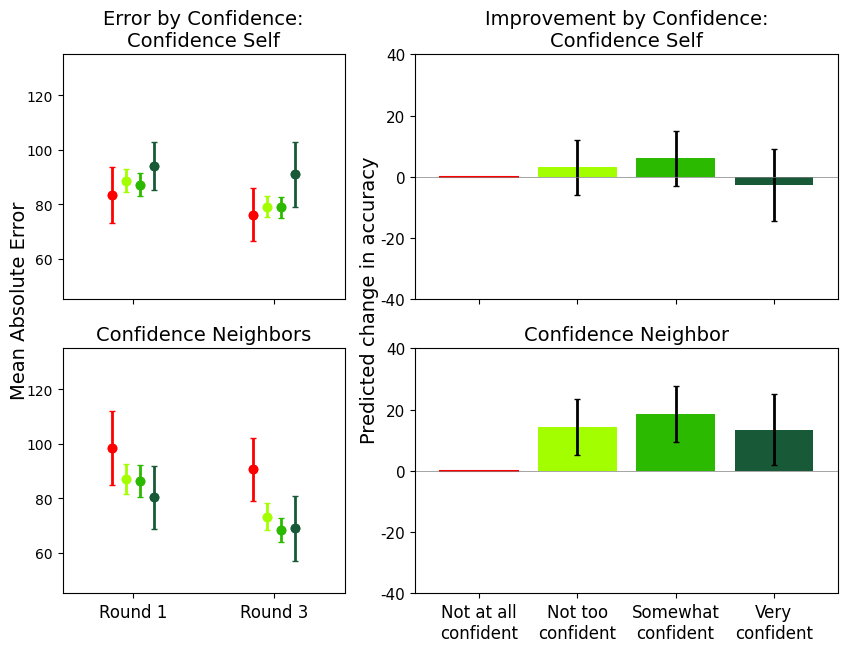

In [21]:
# Plot these results

fig, axs = plt.subplots(2,2,figsize=(10,7),gridspec_kw={'width_ratios': [1, 1.5]})

# Confidence in self -------------------------------------------
options = ['Not at all confident', 'Not too confident', 'Somewhat confident', 'Very confident']
colors = ['#ff0000','#a3ff00','#2cba00','#185a37']
df_temp = df.dropna(subset=['initial_confidence'])
df_temp = df_temp.loc[df_temp.response_1 < 492]
df_temp['Accuracy_1'] = abs(df_temp.response_1 - 246)
df_temp['Accuracy_3'] = abs(df_temp.response_3 - 246)

i = 0
for o in options:
    df_t = df_temp.loc[df_temp.initial_confidence == o]
    axs[0,0].plot([0.85+i,1.85+i],[df_t['Accuracy_1'].mean(), df_t['Accuracy_3'].mean()], color=colors[int(i*10)],marker='o',linestyle='None')
    axs[0,0].errorbar([0.85+i,1.85+i],[df_t['Accuracy_1'].mean(), df_t['Accuracy_3'].mean()],
                [1.96 * df_t[i].std()/np.sqrt(df_t[i].count()) for i in ['Accuracy_1', 'Accuracy_3']],
                capsize=2, color=colors[int(i*10)],lw=2, marker='o',linestyle='None')
    i += 0.1

axs[0,0].set_xticks([1,2])
axs[0,0].set_xticklabels(['',''])
axs[0,0].set_xlim(0.5,2.5)
axs[0,0].set_title('Error by Confidence:\nConfidence Self', fontsize = 14)
axs[0,0].set_ylim(45,135)


# Confidence in neighbors -------------------------------------------
options = ['Not at all confident', 'Not too confident', 'Somewhat confident', 'Very confident']
df_temp = df.dropna(subset=['initial_confidence'])
df_temp = df_temp.loc[df_temp.response_1 < 492]
df_temp['Accuracy_1'] = abs(df_temp.response_1 - 246)
df_temp['Accuracy_3'] = abs(df_temp.response_3 - 246)

i = 0
for o in options:
    df_t = df_temp.loc[df_temp.neighbor_confidence == o]
    axs[1,0].plot([0.85+i,1.85+i],[df_t['Accuracy_1'].mean(), df_t['Accuracy_3'].mean()], color=colors[int(i*10)],marker='o',linestyle='None',label='Control')
    axs[1,0].errorbar([0.85+i,1.85+i],[df_t['Accuracy_1'].mean(), df_t['Accuracy_3'].mean()],
                [1.96 * df_t[i].std()/np.sqrt(df_t[i].count()) for i in ['Accuracy_1', 'Accuracy_3']],
                capsize=2, color=colors[int(i*10)],lw=2, marker='o',linestyle='None')
    i += 0.1

axs[1,0].set_xticks([1,2])
axs[1,0].set_xticklabels(['Round 1', 'Round 3'], fontsize = 12)
axs[1,0].set_ylabel('Mean Absolute Error', fontsize = 14)
axs[1,0].yaxis.set_label_coords(-0.12,1.2)
axs[1,0].set_xlim(0.5,2.5)
axs[1,0].set_title('Confidence Neighbors', fontsize = 14)
axs[1,0].set_ylim(45,135)



# Create a bar plot of the change in accuracy for each confidence level
i = 1
for o in options[:-1]:
    axs[0,1].bar([0+i],[-model_1.params[i]], color=colors[i],label='Control')
    axs[0,1].errorbar([0+i],[-model_1.params[i]],
                [1.96 * model_1.bse[i]],
                capsize=2, color='black',lw=2)
    i += 1
axs[0,1].set_xticks([0,1,2,3])
axs[0,1].plot([-.4,.4],[0,0],'-',color=colors[0])
axs[0,1].set_xticklabels(["","","",""])
axs[0,1].set_title('Improvement by Confidence:\nConfidence Self', fontsize = 14)
axs[0,1].set_yticks([-40,-20,0, 20,40])
axs[0,1].set_yticklabels([-40,-20,0, 20,40],fontsize=11)
axs[0,1].set_ylim(-40,40)
axs[0,1].plot([-1,5],[0,0],'-',color='gray',lw=0.5)
axs[0,1].set_xlim(-.65,3.65)

# Confidence in neighbors -------------------------------------------
options = ['Not at all\nconfident', 'Not too\nconfident', 'Somewhat\nconfident', 'Very\nconfident']

i = 1
for o in options[:-1]:
    axs[1,1].bar([0+i],[-model_2.params[i]], color=colors[i],label='Control')
    axs[1,1].errorbar([0+i],[-model_2.params[i]],
                [1.96 * model_2.bse[i]],
                capsize=2, color='black',lw=2)
    i += 1
axs[1,1].set_xticks([0,1,2,3])
axs[1,1].set_yticks([-40,-20,0, 20,40])
axs[1,1].plot()
axs[1,1].set_yticklabels([-40,-20,0, 20,40],fontsize=11)
axs[1,1].plot([-.4,.4],[0,0],'-',color=colors[0])
axs[1,1].set_xticklabels(options, fontsize = 12)
axs[1,1].set_ylabel('Predicted change in accuracy', fontsize = 14)
axs[1,1].yaxis.set_label_coords(-0.085,1.2)
axs[1,1].plot([-1,5],[0,0],'-',color='gray',lw=0.5)
axs[1,1].set_xlim(-.65,3.65)
axs[1,1].set_title('Confidence Neighbor', fontsize = 14)
axs[1,1].set_ylim(-40,40)

#plt.tight_layout()
plt.savefig('Figures/Figure-4_Confidence.png', dpi=300)
plt.show()
